In [12]:
%matplotlib inline

In [13]:
import matplotlib.pylab as plt
import torch
import numpy as np
import seaborn as sn
sn.set_context("poster")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torchvision import transforms, datasets

from lmu import LegendreMemoryUnit

import numpy as np
import scipy
import scipy.stats as st
import scipy.special
import scipy.signal
import scipy.interpolate

import pandas as pd

from os.path import join
import random
from csv import DictWriter

from tqdm.notebook import tqdm
import pickle
# if gpu is to be used
use_cuda = torch.cuda.is_available()
print(use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
DoubleTensor = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
ttype = FloatTensor

True


In [14]:
import torch
import numpy as np

def get_batch(batch_size, T, ttype):
    values = torch.rand(T, batch_size, requires_grad=False)
    indices = torch.zeros_like(values)
    half = int(T / 2)
    for i in range(batch_size):
        half_1 = np.random.randint(half)
        hals_2 = np.random.randint(half, T)
        indices[half_1, i] = 1
        indices[hals_2, i] = 1

    data = torch.stack((values, indices), dim=-1).type(ttype)
    targets = torch.mul(values, indices).sum(dim=0).type(ttype)
    return data, targets


In [15]:
inp, _ = get_batch(4,500,ttype)

In [16]:
torch.manual_seed(1111)

In [17]:
def train(model, ttype, seq_length, optimizer, loss_func, 
          epoch, perf_file, loss_buffer_size=20, batch_size=1, test_size=10,
          device='cuda', prog_bar=None):
    assert(loss_buffer_size%batch_size==0)

    losses = []
    perfs = []
    last_test_perf = 0
    for batch_idx in range(20000):
        model.train()
        sig, target = get_batch(batch_size, seq_length, ttype=ttype)
        
        target = target.unsqueeze(1)
        optimizer.zero_grad()
        out = model(sig.transpose(1,0))
        loss = loss_func(out[:, -1],
                         target)
         
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        losses = losses[-loss_buffer_size:]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.8f}"
            format_list = [e, int(batch_idx/(50/batch_size)), np.mean(losses)]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            #last_test_perf = test_norm(model, 'cuda', test_sig, test_class,
            #                                    batch_size=test_size, 
            #                                    )
            loss_track['avg_loss'] = np.mean(losses)
            #loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
def test_norm(model, device, seq_length, loss_func, batch_size=100):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        sig, target = get_batch(batch_size, seq_length, ttype=ttype)
        target = target.unsqueeze(1)
        out = model(sig.transpose(1,0))
        loss = loss_func(out[:, -1],
                         target)
    return loss

In [30]:
class LMUModel(nn.Module):
    def __init__(self, n_out, layer_params):
        super(LMUModel, self).__init__()
        self.layers = nn.ModuleList([LegendreMemoryUnit(**layer_params[i])
                                      for i in range(len(layer_params))])
        self.dense = nn.Linear(layer_params[-1]['hidden_size'], n_out)

        
    def forward(self, x):
        for l in self.layers:
            x, _ = l(x)    
        x = self.dense(x)
        return x

# T = 500

In [47]:
seq_length=500

lmu_params = [dict(input_dim=2, hidden_size=10, order=100, theta=seq_length),
              
             ]
model = LMUModel(1, lmu_params).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)


Total Weights: 11343
LMUModel(
  (layers): ModuleList(
    (0): LegendreMemoryUnit(
      (lmucell): LMUCell()
    )
  )
  (dense): Linear(in_features=10, out_features=1, bias=True)
)


In [48]:

model(inp.transpose(1,0)).shape


torch.Size([4, 500, 1])

In [49]:

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
epochs = 1yh 
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding500_lmu_8.csv'),
          prog_bar=progress_bar)

# T = 2000

In [50]:
seq_length=2000

lmu_params = [dict(input_dim=2, hidden_size=10, order=100, theta=seq_length),
              
             ]
model = LMUModel(1, lmu_params).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 11343
LMUModel(
  (layers): ModuleList(
    (0): LegendreMemoryUnit(
      (lmucell): LMUCell()
    )
  )
  (dense): Linear(in_features=10, out_features=1, bias=True)
)


In [51]:

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
epochs = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding2000_lmu_1.csv'),
          prog_bar=progress_bar)

#  T = 5000

In [52]:
seq_length=5000

lmu_params = [dict(input_dim=2, hidden_size=10, order=100, theta=seq_length),
             ]
model = LMUModel(1, lmu_params).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 11343
LMUModel(
  (layers): ModuleList(
    (0): LegendreMemoryUnit(
      (lmucell): LMUCell()
    )
  )
  (dense): Linear(in_features=10, out_features=1, bias=True)
)


In [53]:

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
epochs = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding5000_lmu_1.csv'),
          prog_bar=progress_bar)

# Data Plot

In [4]:
dat = pd.read_csv(os.path.join('perf', 'adding500_deepsith_6.csv'))
dat2 = pd.read_csv(os.path.join('perf', 'adding2000_deepsith_2.csv'))
dat3 = pd.read_csv(os.path.join('perf', 'adding5000_deepsith_1.csv'))

In [5]:
dat['training_step'] = (dat.batch_idx)/100
dat2['training_step'] = (dat2.batch_idx)/100
dat3['training_step'] = (dat3.batch_idx)*10/5/100


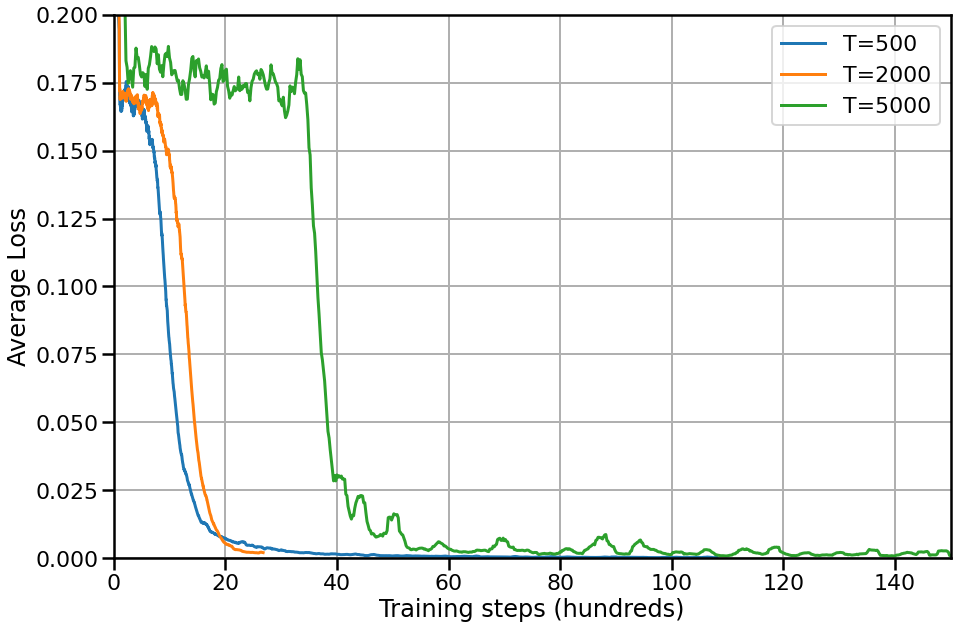

In [8]:

fig = plt.figure(figsize=(15,10))
sn.lineplot(data=dat, x=dat.training_step, y=dat.avg_loss,)
sn.lineplot(data=dat2, x=dat2.training_step, y=dat2.avg_loss,)
ax = sn.lineplot(data=dat3, x=dat3.training_step, y=dat3.avg_loss,)
plt.legend(['T=500', 'T=2000', 'T=5000'])
ax.set_xlabel('Training steps (hundreds)')
ax.set_ylabel('Average Loss')
ax.set_xlim(0, 150)
ax.set_ylim(0, .2)
plt.grid(True)
